In [1072]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from skimage import io
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn import metrics

In [1073]:
from util.spotify_api_service import SpotifyApiService

In [1074]:
dados = pd.read_csv('data/musicas.csv')

In [1075]:
dados.head(2)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,artists_song
0,0.285,2000,0.00239,Coldplay,0.429,266773,0.661,0,3AJwUDP919kvQ9QcozQPxg,0.000121,11,0.2340,-7.227,1,Yellow,84,0.0281,173.372,Coldplay - Yellow
1,0.613,2000,0.14300,OutKast,0.843,270507,0.806,1,0I3q5fE6wg7LIfHGngUTnV,0.000000,4,0.0771,-5.946,0,Ms. Jackson,80,0.2690,94.948,OutKast - Ms. Jackson


In [1076]:
dados["year"].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
      dtype=int64)

In [1077]:
dados.shape

(20311, 19)

Removendo colunas que não agregam valor ao modelo

In [1078]:
dados.drop(
    [
        "explicit",
        "key",
        "mode"
    ],
    axis=1,
    inplace=True
)

dados.head(2)

,valence,year,acousticness,artists,danceability,duration_ms,energy,id,instrumentalness,liveness,loudness,name,popularity,speechiness,tempo,artists_song
0,0.285,2000,0.00239,Coldplay,0.429,266773,0.661,3AJwUDP919kvQ9QcozQPxg,0.000121,0.2340,-7.227,Yellow,84,0.0281,173.372,Coldplay - Yellow
1,0.613,2000,0.14300,OutKast,0.843,270507,0.806,0I3q5fE6wg7LIfHGngUTnV,0.000000,0.0771,-5.946,Ms. Jackson,80,0.2690,94.948,OutKast - Ms. Jackson


Verificando valores faltantes

In [1079]:
dados.isna().sum().sort_values(ascending=False)

valence             0
year                0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
id                  0
instrumentalness    0
liveness            0
loudness            0
name                0
popularity          0
speechiness         0
tempo               0
artists_song        0
dtype: int64

Salvando colunas para reuni-las pós clusterização

In [1080]:
colunas_identificadoras_musica = [
    'id',
    'artists',
    'name',
    'artists_song'
]

df_identificacao = dados.loc[
    :,
    colunas_identificadoras_musica
]

dados.drop(
    colunas_identificadoras_musica,
    axis=1,
    inplace=True
)

In [1081]:
df_identificacao.head(2)

,id,artists,name,artists_song
0,3AJwUDP919kvQ9QcozQPxg,Coldplay,Yellow,Coldplay - Yellow
1,0I3q5fE6wg7LIfHGngUTnV,OutKast,Ms. Jackson,OutKast - Ms. Jackson


In [1082]:
dados.head(2)

,valence,year,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo
0,0.285,2000,0.00239,0.429,266773,0.661,0.000121,0.2340,-7.227,84,0.0281,173.372
1,0.613,2000,0.14300,0.843,270507,0.806,0.000000,0.0771,-5.946,80,0.2690,94.948


Configurando parâmetros de randomicidade

In [1083]:
SEED = 1224
np.random.seed(SEED)

verificando se exitem colunas fortemente correlacionadas

c:\Users\paulo\dev\projetos\PESSOAL\recomendador_musical\.venv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\paulo\dev\projetos\PESSOAL\recomendador_musical\.venv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


<Axes: >

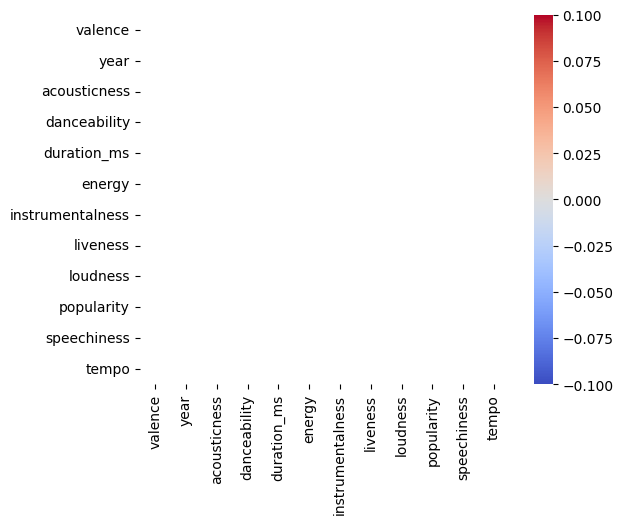

In [1084]:
matriz_correlacao = dados.corr()

mask = np.zeros_like(matriz_correlacao, dtype=bool)
mask[np.triu_indices_from(mask)] = True

matriz_correlacao[abs(matriz_correlacao) < 0.8] = np.nan

sns.heatmap(
    matriz_correlacao,
    annot=True,
    mask=mask,
    fmt='.1f',
    cmap='coolwarm',
    square=True
)

Verificando questão de coluna de artistas e músicas

In [1085]:
df_identificacao['artists'].value_counts()
     

artists
Drake                   170
Taylor Swift            156
Eminem                  147
Kanye West              136
BTS                     122
                       ... 
Of Monsters and Men       7
The Living Tombstone      7
Clean Bandit              7
Nelly Furtado             6
Empire of the Sun         6
Name: count, Length: 875, dtype: int64

In [1086]:
df_identificacao['artists_song'].value_counts()

artists_song
Coldplay - Yellow                                                   1
Juice WRLD - Intro                                                  1
Carrie Underwood - The Champion - Bonus Track                       1
YoungBoy Never Broke Again - Cross Me (feat. Lil Baby and Plies)    1
Twenty One Pilots - Morph                                           1
                                                                   ..
Taylor Swift - Come Back...Be Here                                  1
Banda El Recodo - Me Gusta Todo De Ti                               1
Michael Bublé - The Christmas Song                                  1
Glee Cast - Smooth Criminal (Glee Cast Version) (feat. 2CELLOS)     1
Eminem - Darkness                                                   1
Name: count, Length: 20311, dtype: int64

In [1087]:
ohe = OneHotEncoder(dtype=int)
colunas_ohe = ohe.fit_transform(df_identificacao[['artists']]).toarray()

dados_musicas_dummies = pd.concat([dados, pd.DataFrame(colunas_ohe, columns=ohe.get_feature_names_out(['artists']))], axis=1)
dados_musicas_dummies.head(2)

,valence,year,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,...,artists_Zara Larsson,artists_Zedd,artists_alt-J,artists_blackbear,artists_blink-182,artists_deadmau5,artists_for KING & COUNTRY,artists_fun.,artists_girl in red,artists_iann dior
0,0.285,2000,0.00239,0.429,266773,0.661,0.000121,0.2340,-7.227,84,...,0,0,0,0,0,0,0,0,0,0
1,0.613,2000,0.14300,0.843,270507,0.806,0.000000,0.0771,-5.946,80,...,0,0,0,0,0,0,0,0,0,0


In [1088]:
print(f'QTD de colunas pre dummies {dados.shape[1]} QTD pós dummies: {dados_musicas_dummies.shape[1]}')

QTD de colunas pre dummies 12 QTD pós dummies: 887


In [1089]:
pca_pipeline = Pipeline(
    [
        ('scaler', StandardScaler()),                     # Normalizando valores
        ('PCA', PCA(n_components=0.7, random_state=SEED)) # Reduzindo dimensionalidades
    ]
)

music_embedding_pca = pca_pipeline.fit_transform(dados_musicas_dummies)
projection_m = pd.DataFrame(data=music_embedding_pca)

In [1090]:
print(f'Quantidade de colunas pós PCA: {pca_pipeline[1].n_components_}')

Quantidade de colunas pós PCA: 612


In [1091]:
projection_m.head(2)

,0,1,2,3,4,5,6,7,8,9,...,602,603,604,605,606,607,608,609,610,611
0,0.174796,0.731252,2.186797,-0.767192,0.594847,0.315968,-0.412322,-0.479171,-2.700668,2.109956,...,0.002516,0.002097,-0.019072,-0.009111,0.005154,-0.034027,-0.032617,6.232226e-12,-4.151492e-12,-4.959043e-14
1,-1.358420,0.052935,-1.789973,1.938444,0.403606,1.023898,-1.172118,0.821698,-1.716897,0.252498,...,0.036047,-0.026825,-0.031678,-0.031986,0.029708,-0.016322,-0.030234,1.608076e-12,-2.982306e-12,8.809321e-13


In [1092]:
modelo_kmeans = KMeans(n_clusters=50, random_state=SEED)

modelo_kmeans.fit(projection_m)

previsoes = modelo_kmeans.predict(projection_m)

dados['cluster_pca'] = previsoes
projection_m['cluster_pca'] = previsoes

In [1093]:
inertia = modelo_kmeans.inertia_
silhouette_avg = silhouette_score(projection_m, previsoes)
db = metrics.davies_bouldin_score(projection_m, previsoes)
ch = metrics.calinski_harabasz_score(projection_m, previsoes)

### Inércia <sub><sup>*Mede a variabilidade dentro dos clusters*</sup></sub>
- Quanto menor melhor

In [1094]:
print(f'{inertia:.2f}')

11565130.22


### Silhueta <sub><sup>*Mede a coesão intra-cluster e a separação inter-cluster*</sup></sub>
- Entre -1 e 1
- valores mais altos indicam clusters mais densos e bem separados

In [1095]:
print(f'{silhouette_avg:.2f}')

-0.08


### Índice Davies-Bouldin <sub><sup>*"similaridade" média entre cada cluster e seu cluster mais próximo*</sup></sub>
- clusters com valores menores são considerados melhores

In [1096]:
print(f'Davies-Bouldin: {db:.2f}')

Davies-Bouldin: 1.46


### Índice de Calinski-Harabasz <sub><sup>*Mede a dispersão entre e dentro dos clusters*</sup></sub>
- valores mais altos indicam clusters mais densos e bem definidos

In [1097]:
print(f'{ch:.2f}')

165.02


In [1098]:
projection_m.head(1)

,0,1,2,3,4,5,6,7,8,9,...,603,604,605,606,607,608,609,610,611,cluster_pca
0,0.174796,0.731252,2.186797,-0.767192,0.594847,0.315968,-0.412322,-0.479171,-2.700668,2.109956,...,0.002097,-0.019072,-0.009111,0.005154,-0.034027,-0.032617,6.232226e-12,-4.151492e-12,-4.959043e-14,43


Visualizando clusters

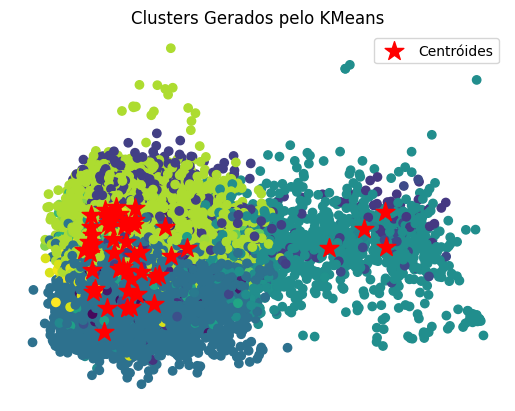

In [1099]:
plt.scatter(
    projection_m[0],
    projection_m[1],
    c=previsoes,
    cmap='viridis'
)
plt.scatter(
    modelo_kmeans.cluster_centers_[:, 0],
    modelo_kmeans.cluster_centers_[:, 1],
    s=200,
    c='red',
    marker='*',
    label='Centróides'
)
plt.axis('off')
plt.title('Clusters Gerados pelo KMeans')
plt.legend()
plt.show()

In [1100]:
sp_api_service: SpotifyApiService = SpotifyApiService()
sp_api_service.conectar()

In [1101]:
projection_m = pd.concat([df_identificacao, projection_m], axis=1)

In [1102]:
projection_m.head(2)

,id,artists,name,artists_song,0,1,2,3,4,5,...,603,604,605,606,607,608,609,610,611,cluster_pca
0,3AJwUDP919kvQ9QcozQPxg,Coldplay,Yellow,Coldplay - Yellow,0.174796,0.731252,2.186797,-0.767192,0.594847,0.315968,...,0.002097,-0.019072,-0.009111,0.005154,-0.034027,-0.032617,6.232226e-12,-4.151492e-12,-4.959043e-14,43
1,0I3q5fE6wg7LIfHGngUTnV,OutKast,Ms. Jackson,OutKast - Ms. Jackson,-1.358420,0.052935,-1.789973,1.938444,0.403606,1.023898,...,-0.026825,-0.031678,-0.031986,0.029708,-0.016322,-0.030234,1.608076e-12,-2.982306e-12,8.809321e-13,43


In [1103]:
def recomendar(nome_musica):

  linha_da_musica = projection_m.loc[
      projection_m['artists_song'] == nome_musica
  ]

  if linha_da_musica.empty:
     print('Música não presente neste dataset')
     return
  
  cluster = list(linha_da_musica['cluster_pca'])[0]
  x_musica = list(linha_da_musica[0])[0]
  y_musica = list(linha_da_musica[1])[0]

  musicas_recomendadas = projection_m[projection_m['cluster_pca'] == cluster][[0, 1, 'id', 'artists_song']]

  distancias = euclidean_distances(musicas_recomendadas[[0, 1]], [[x_musica, y_musica]])
  musicas_recomendadas['distancias'] = distancias
  recomendada = musicas_recomendadas.sort_values('distancias').head(11)

  playlist_id = recomendada['id']

  url = []
  name = []

  for i in playlist_id:
      track = sp_api_service.getTrack(i)
      url.append(track["album"]["images"][1]["url"])
      name.append(f'{track["artists"][0]["name"]} \n {track["name"]}')
  
  plt.figure(figsize=(13,8))

  ax_line = plt.subplot(3, 5, 3)
  image_line = io.imread(url[0])
  plt.imshow(image_line)
  ax_line.get_yaxis().set_visible(False)
  plt.xticks([])
  plt.yticks(color = 'w', fontsize = 0.1)
  plt.xlabel(name[0], fontsize = 10, wrap=True)

  url = url[1:]
  name = name[1:]

  columns = 5
  for i, u in enumerate(url):
      ax = plt.subplot(3, columns, i + 6)
      image = io.imread(u)
      plt.imshow(image)
      ax.get_yaxis().set_visible(False)
      plt.xticks([])
      plt.xlabel(name[i], fontsize = 10, wrap=True)
      plt.yticks(color = 'w', fontsize = 0.1)
      plt.tight_layout(h_pad=0.7, w_pad=0.5)
      plt.subplots_adjust(wspace=None, hspace=None)
      plt.grid(visible=None)
      plt.tick_params(bottom = False)
  plt.show()

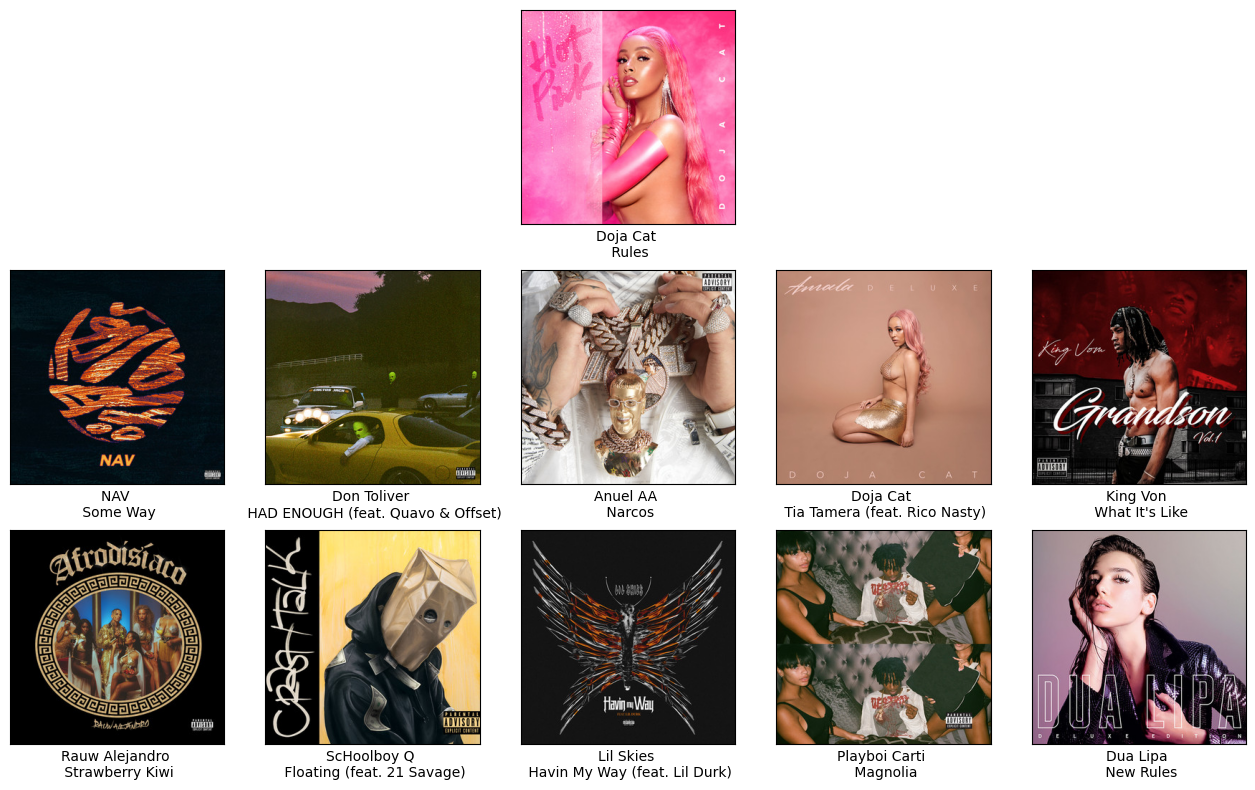

In [1104]:
recomendar('Doja Cat - Rules')